## 합성곱 신경망을 사용한 이미지 분류

In [1]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

### 패션 MNIST 데이터 불러오기

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()
train_scaled=train_input.reshape(-1,28,28,1)/255.0 #2차원 배열 그대로 사용하며 깊이가 1임

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

![데이터](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcYfrNN%2FbtrkvIMWkw5%2FCuYJ2TQ14Jsz5TJzJrvAc0%2Fimg.png)

### 합성곱 신경망 만들기

![합성곱](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbYj5Xu%2FbtrkyPLe9j5%2FUntgosNjVlZLTSKiVS3tjK%2Fimg.png)

In [3]:
model=keras.Sequential()

In [4]:
#32개의 필터, 커널의 크기는 (3,3), 첫 번째 층에서 입력의 차원 지정
#32개가 쌓이며 same padding을 사용했기 때문에 너비와 높이가 28*28로 유지되며 깊이도 32개가 채워짐
model.add(keras.layers.Conv2D(32,kernel_size=3,activation='relu',padding='same',input_shape=(28,28,1)))

In [5]:
#첫 번째 최대 풀링 층 추가 
#28*28 -> 14*14로 줄어듦, 깊이는 동일하게 유지됨
model.add(keras.layers.MaxPooling2D(2))

![합성곱](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FyX2Bb%2FbtrkxOFyHjC%2FrhySZLPQKulm9TVkhkiVGK%2Fimg.png)

In [6]:
#두 번째 합성곱 층 추가
#필터의 개수를 64개로 늘린 것만 다르고 나머지는 모두 같음
#풀링 층에서 가로, 세로의 크기를 절반으로 줄어 최종 특성 맵의 크기는 (7,7,64)가 됨
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same')) #(14,14,64)
model.add(keras.layers.MaxPooling2D(2)) #(7,7,64)

In [7]:
model.add(keras.layers.Flatten()) #3차원 특성 맵을 일렬로 펼침->밀집층에서 확률을 계산하기 때문
model.add(keras.layers.Dense(100,activation='relu'))#첫 번째 은닉층(뉴런 100개)
model.add(keras.layers.Dropout(0.4)) #40%정도 뉴런을 훈련시에 끄도록 지정(과대적합 막음)
model.add(keras.layers.Dense(10,activation='softmax'))#10개의 확률을 얻음

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

첫번째 합성곱 층은 32개의 필터를 가지고 있고 크기가 (3,3)이며 깊이는 1이다.<br>
$ 3 \times 3 \times 1 \times 32 + 32 = 320 $개의 파라미터<br>
두번째 합성곱 층은 64개의 필터를 가지고 있고 크기가 (3,3)이며 깊이는 32이다.<br>
$ 3 \times 3 \times 32 \times 64 + 64 = 18496 $개의 파라미터<br>
**합성곱 층은 적은 개수의 파라미터로도 효과적으로 이미지의 특징을 잘 잡아낼 수 있음**<br><br>
은닉층의 모델 파라미터의 개수는 $ 3136 \times 100 + 100 = 313700 $개<br>
**완전연결층은 과대적합 되기 쉬움**<br>
출력층의 모델 파라미터 개수는 $ 100 \times 10 + 10 = 1010 $개

In [9]:
keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
#show_shapes=True: 입출력 크기 표시, to_file: 파일로 저장, dpi: 해상도 지정
keras.utils.plot_model(model,show_shapes=True,to_file='cnn-architecture.png',dpi=300)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### 모델 컴파일과 훈련

In [11]:
#훈련 세트의 정확도 상승
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
history=model.fit(train_scaled,train_target,epochs=20,validation_data=(val_scaled,val_target),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.5391 - accuracy: 0.8070 - val_loss: 0.3316 - val_accuracy: 0.8789
Epoch 2/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.3531 - accuracy: 0.8735 - val_loss: 0.2782 - val_accuracy: 0.8964
Epoch 3/20
1500/1500 [==============================] - 14s 10ms/step - loss: 0.3025 - accuracy: 0.8901 - val_loss: 0.2561 - val_accuracy: 0.9052
Epoch 4/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2704 - accuracy: 0.9034 - val_loss: 0.2396 - val_accuracy: 0.9126
Epoch 5/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2418 - accuracy: 0.9113 - val_loss: 0.2464 - val_accuracy: 0.9126
Epoch 6/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2253 - accuracy: 0.9175 - val_loss: 0.2196 - val_accuracy: 0.9210
Epoch 7/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2089 - accuracy: 0.9238 - val_loss: 0.2116 -

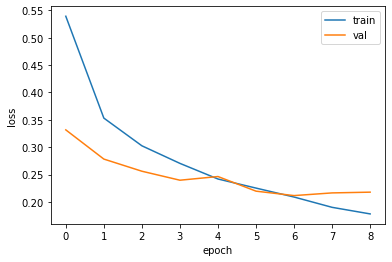

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [13]:
model.evaluate(val_scaled,val_target) #약 92%

375/375 [==============================] - 1s 3ms/step - loss: 0.2116 - accuracy: 0.9233


[0.2115595042705536, 0.9233333468437195]

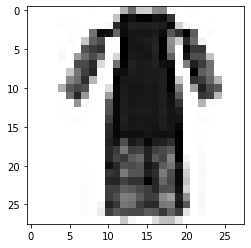

In [14]:
plt.imshow(val_scaled[10].reshape(28,28),cmap='gray_r') #흑백은 깊이 차원이 업어서 (28,28)로 바꾸어 출력
plt.show()

In [15]:
preds=model.predict(val_scaled[10:11])
print(preds) #4번째 값이 거의 1에 가까움

1/1 [==============================] - 0s 73ms/step
[[1.4727088e-02 7.1855857e-06 3.3995289e-05 9.6267784e-01 1.9206259e-03
  3.0400338e-06 2.0532688e-02 3.3383509e-07 9.5379517e-05 1.8696089e-06]]


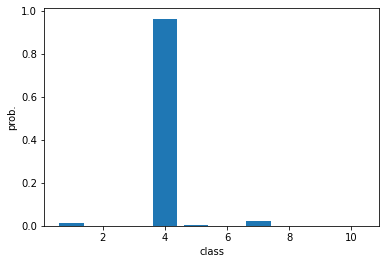

In [16]:
plt.bar(range(1,11),preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [17]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클부츠']

import numpy as np
print(classes[np.argmax(preds)])

드레스


In [18]:
#테스트 세트로 합성곱 신경망 일반화 성능 측정
#픽셀값 범위 0~1, 이미지 크기를 (28,28,1)로 바꿈
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [19]:
model.evaluate(test_scaled, test_target) #약 91%

313/313 [==============================] - 1s 3ms/step - loss: 0.2285 - accuracy: 0.9172


[0.22853611409664154, 0.9172000288963318]